In [ ]:
# Train VAE using MNIST

In [ ]:
from tensorflow import keras # for building Neural Networks
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import plotly
import plotly.express as px
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])
# Load digits data 
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print shapes
print("Shape of X_train: ", X_train.shape)
# Normalize input data (divide by 255) 
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

Tensorflow/Keras: 2.9.0
11490434/11490434 [==============================] - 2s 0us/step
Shape of X_train:  (60000, 28, 28)


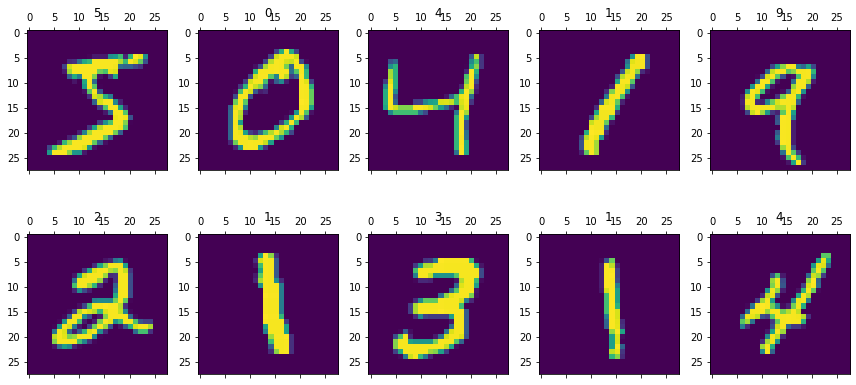

In [ ]:
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

In [ ]:
# Reshape input data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon
  
original_dim = 784 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2 # latent space dimension

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')



In [ ]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

Epoch 1/25
3750/3750 [==============================] - 22s 4ms/step - loss: 50.9734 - val_loss: 48.2560
Epoch 2/25
3750/3750 [==============================] - 14s 4ms/step - loss: 44.7903 - val_loss: 43.0916
Epoch 3/25
3750/3750 [==============================] - 13s 4ms/step - loss: 42.2256 - val_loss: 41.2943
Epoch 4/25
3750/3750 [==============================] - 13s 4ms/step - loss: 40.8089 - val_loss: 40.1666
Epoch 5/25
3750/3750 [==============================] - 14s 4ms/step - loss: 39.5271 - val_loss: 38.4427
Epoch 6/25
3750/3750 [==============================] - 14s 4ms/step - loss: 37.8693 - val_loss: 37.3638
Epoch 7/25
3750/3750 [==============================] - 13s 4ms/step - loss: 37.0799 - val_loss: 36.8361
Epoch 8/25
3750/3750 [==============================] - 13s 4ms/step - loss: 36.5382 - val_loss: 36.0546
Epoch 9/25
3750/3750 [==============================] - 15s 4ms/step - loss: 36.0237 - val_loss: 35.7798
Epoch 10/25
3750/3750 [==============================] 

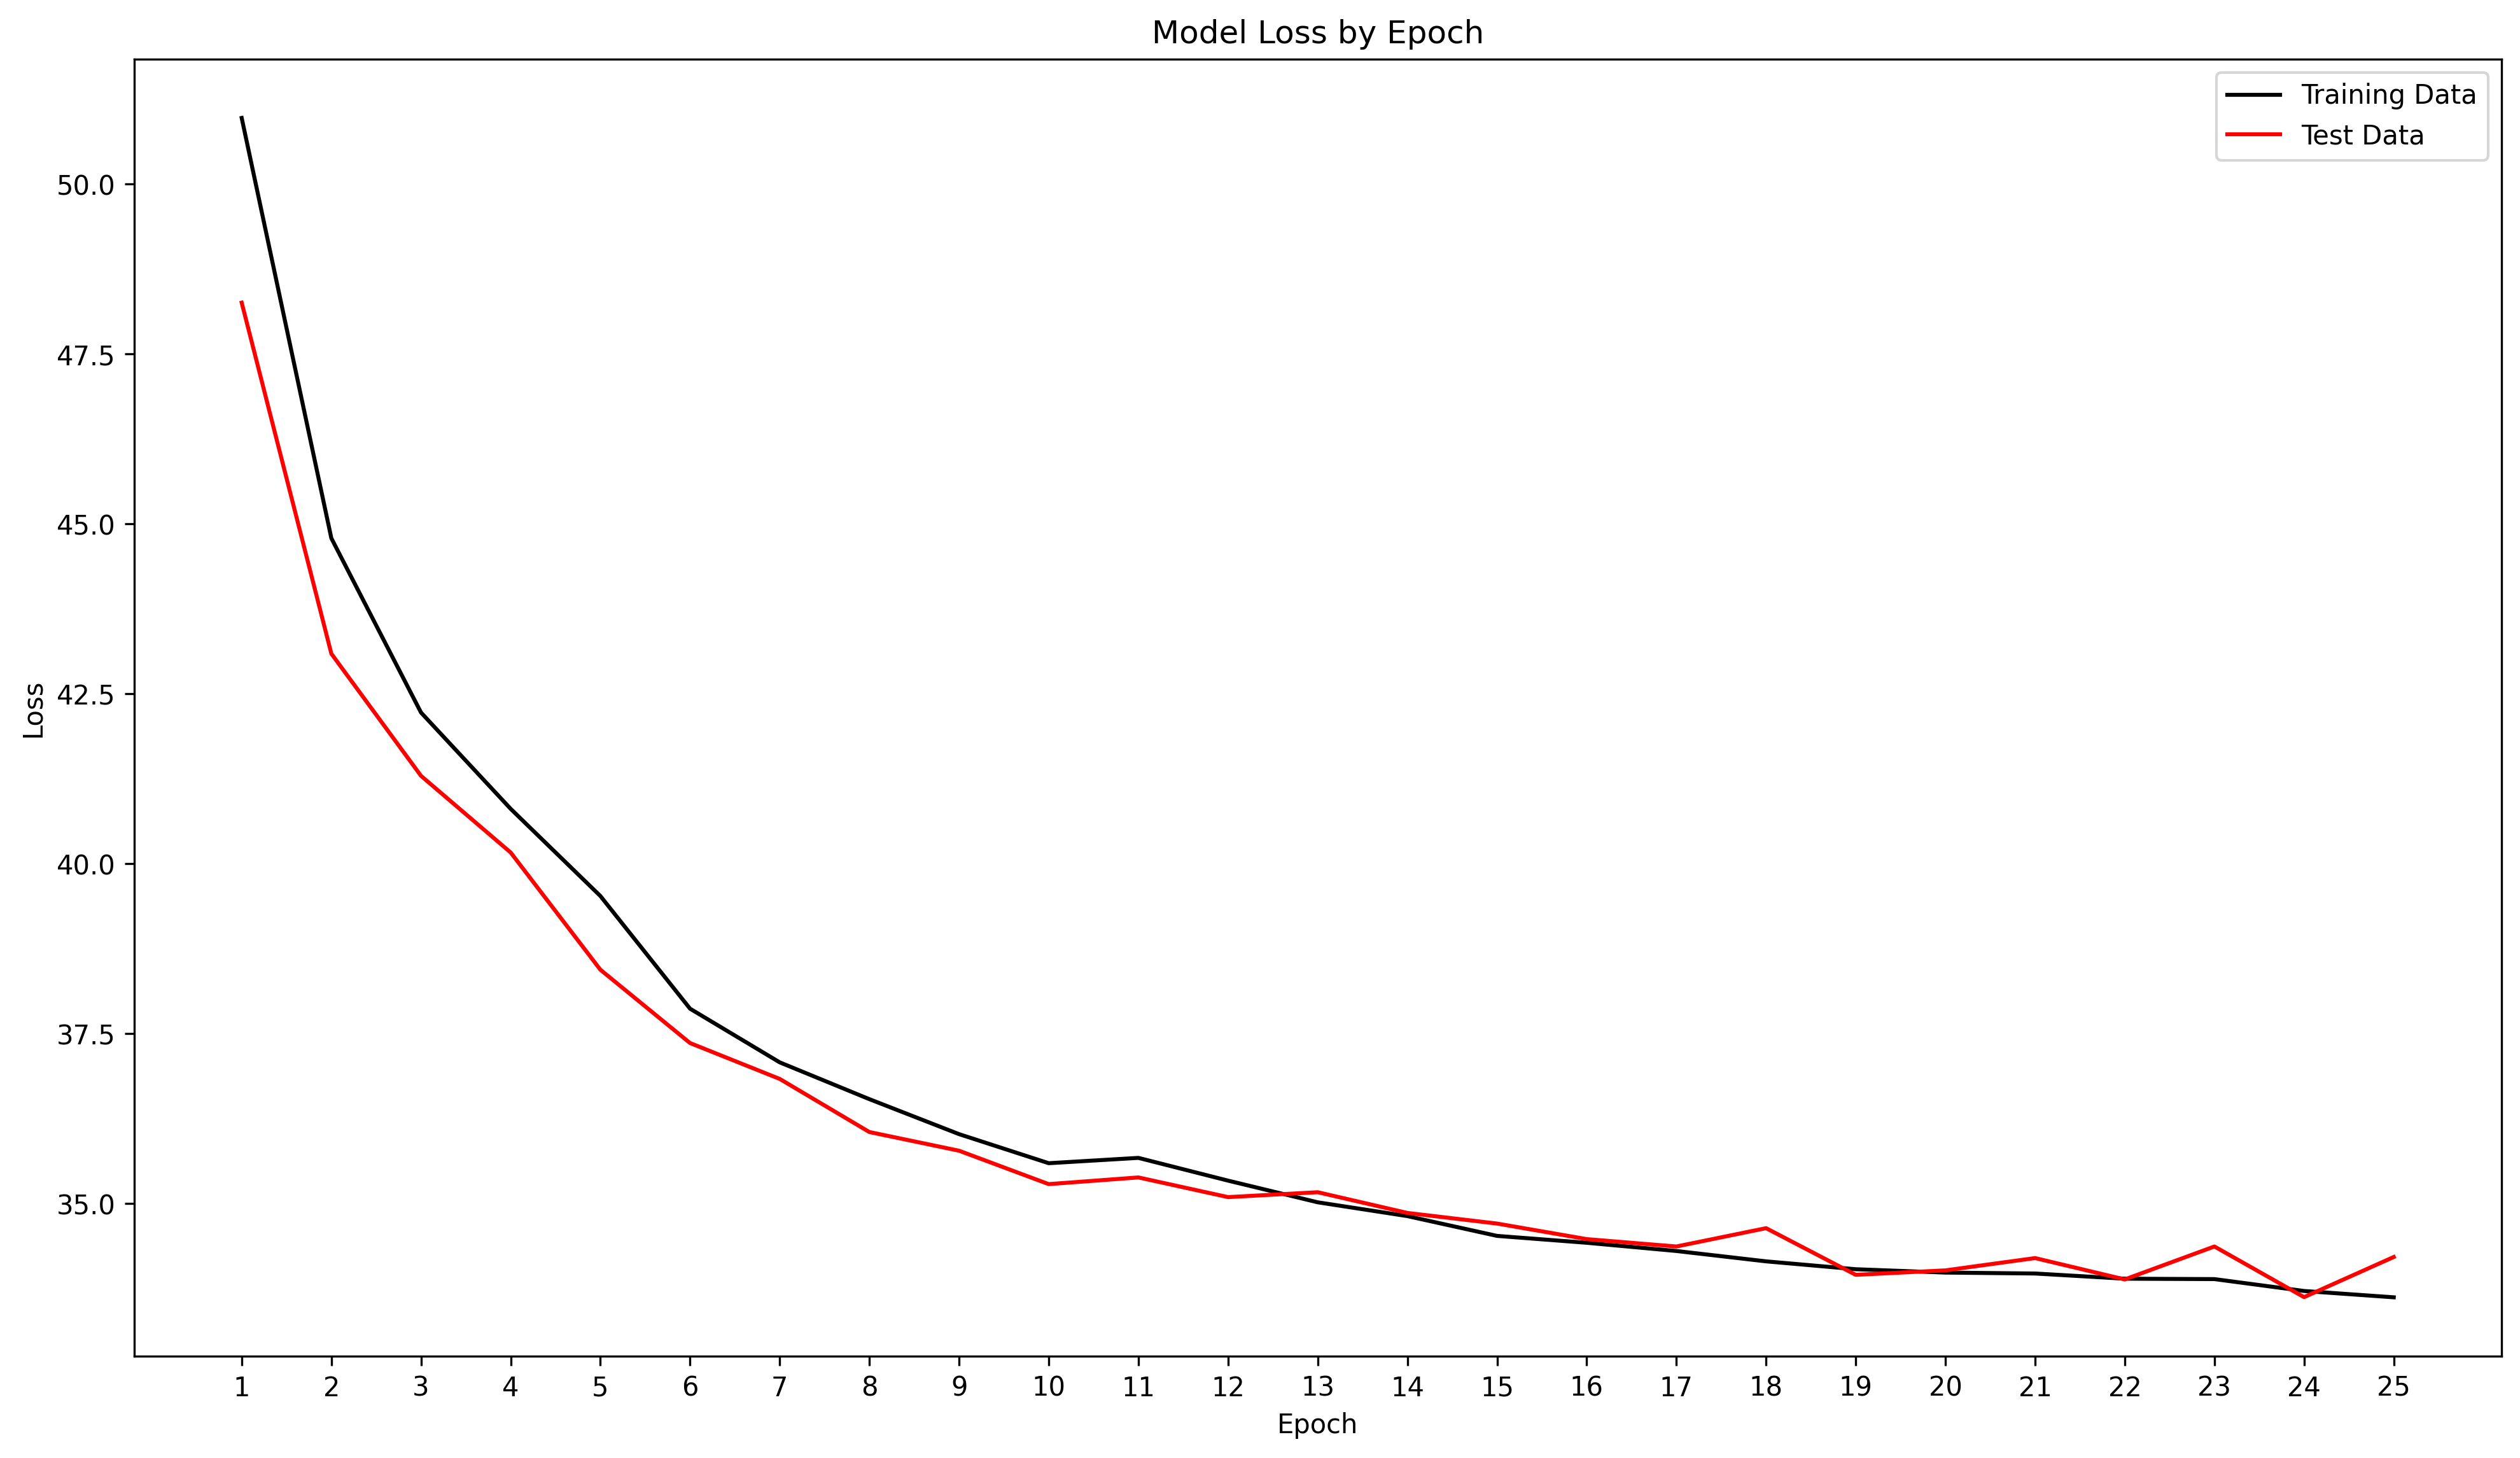

In [ ]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train VAE model
history = vae.fit(X_train, X_train, epochs=10, batch_size=16, validation_data=(X_test, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

1/1 [==============================] - 0s 14ms/step


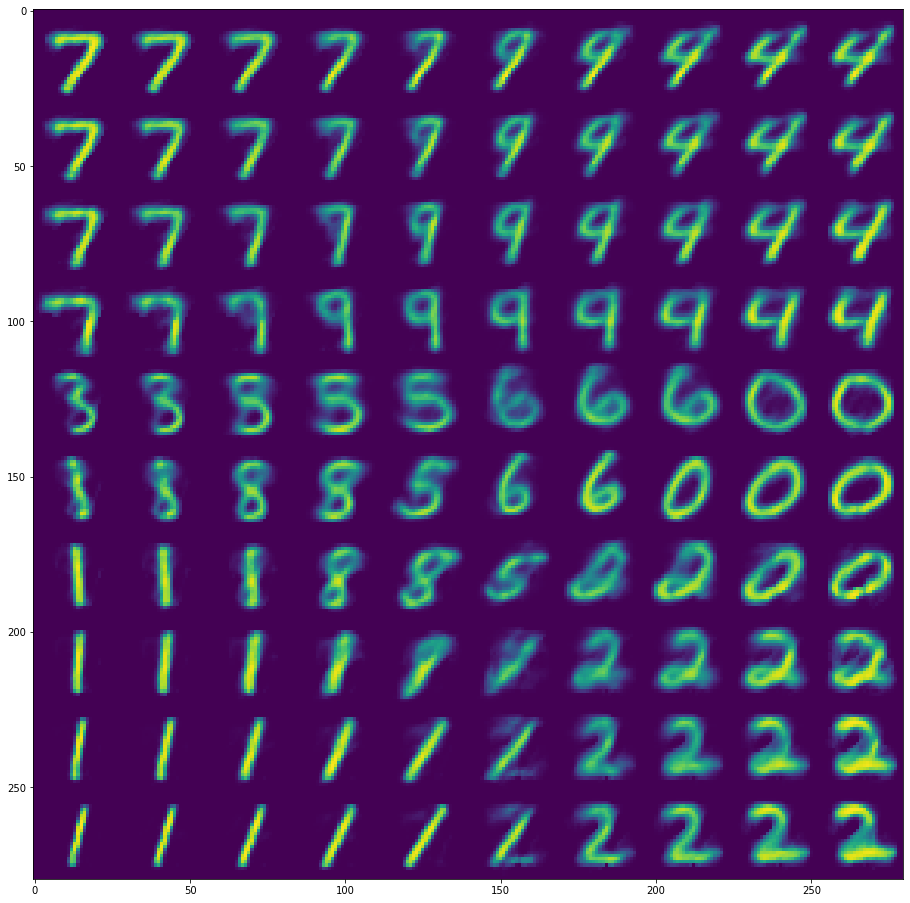

In [ ]:
n = 10  # figure with 10x10 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker
        
        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

In [ ]:
# Train VAE using CIFAR10 


170498071/170498071 [==============================] - 2s 0us/step


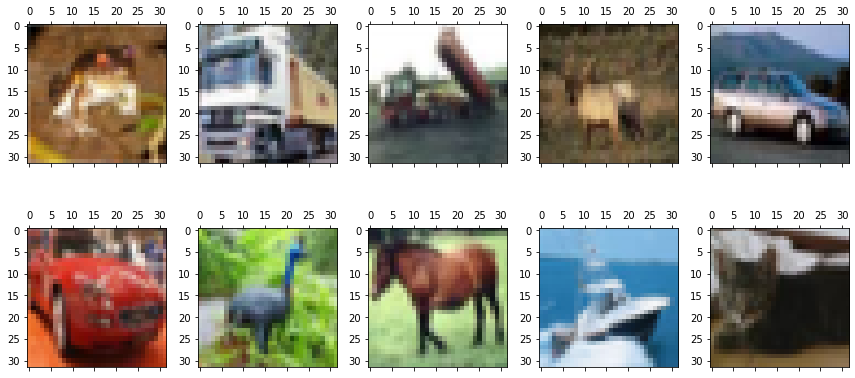

In [ ]:
from tensorflow import keras
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import graphviz
import plotly
import plotly.express as px
import sys
import os

from tensorflow.keras.datasets.cifar10 import load_data
(Xc_train, yc_train), (Xc_test, yc_test) = load_data()

fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(Xc_train[n])
        #axs[i,j].set(title=yc_train[n])
        n=n+1
plt.show()


In [ ]:
# Reshape input data
Xc_train = Xc_train.reshape(150000, 1024)
Xc_test = Xc_test.reshape(30000, 1024)
Xc_train = Xc_train.astype("float32") / 255
Xc_test = Xc_test.astype("float32") / 255  
original_dim_c = 1024 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2 # latent space dimension

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(original_dim_c,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(original_dim_c, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

In [ ]:
outputs

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'Decoder-Output-Layer')>

Epoch 1/5
9375/9375 [==============================] - 27s 3ms/step - loss: 64.7250 - val_loss: 64.5347
Epoch 2/5
9375/9375 [==============================] - 24s 3ms/step - loss: 64.7042 - val_loss: 64.5194
Epoch 3/5
9375/9375 [==============================] - 26s 3ms/step - loss: 64.7044 - val_loss: 64.5324
Epoch 4/5
9375/9375 [==============================] - 25s 3ms/step - loss: 64.7042 - val_loss: 64.5395
Epoch 5/5
9375/9375 [==============================] - 27s 3ms/step - loss: 64.7041 - val_loss: 64.5450


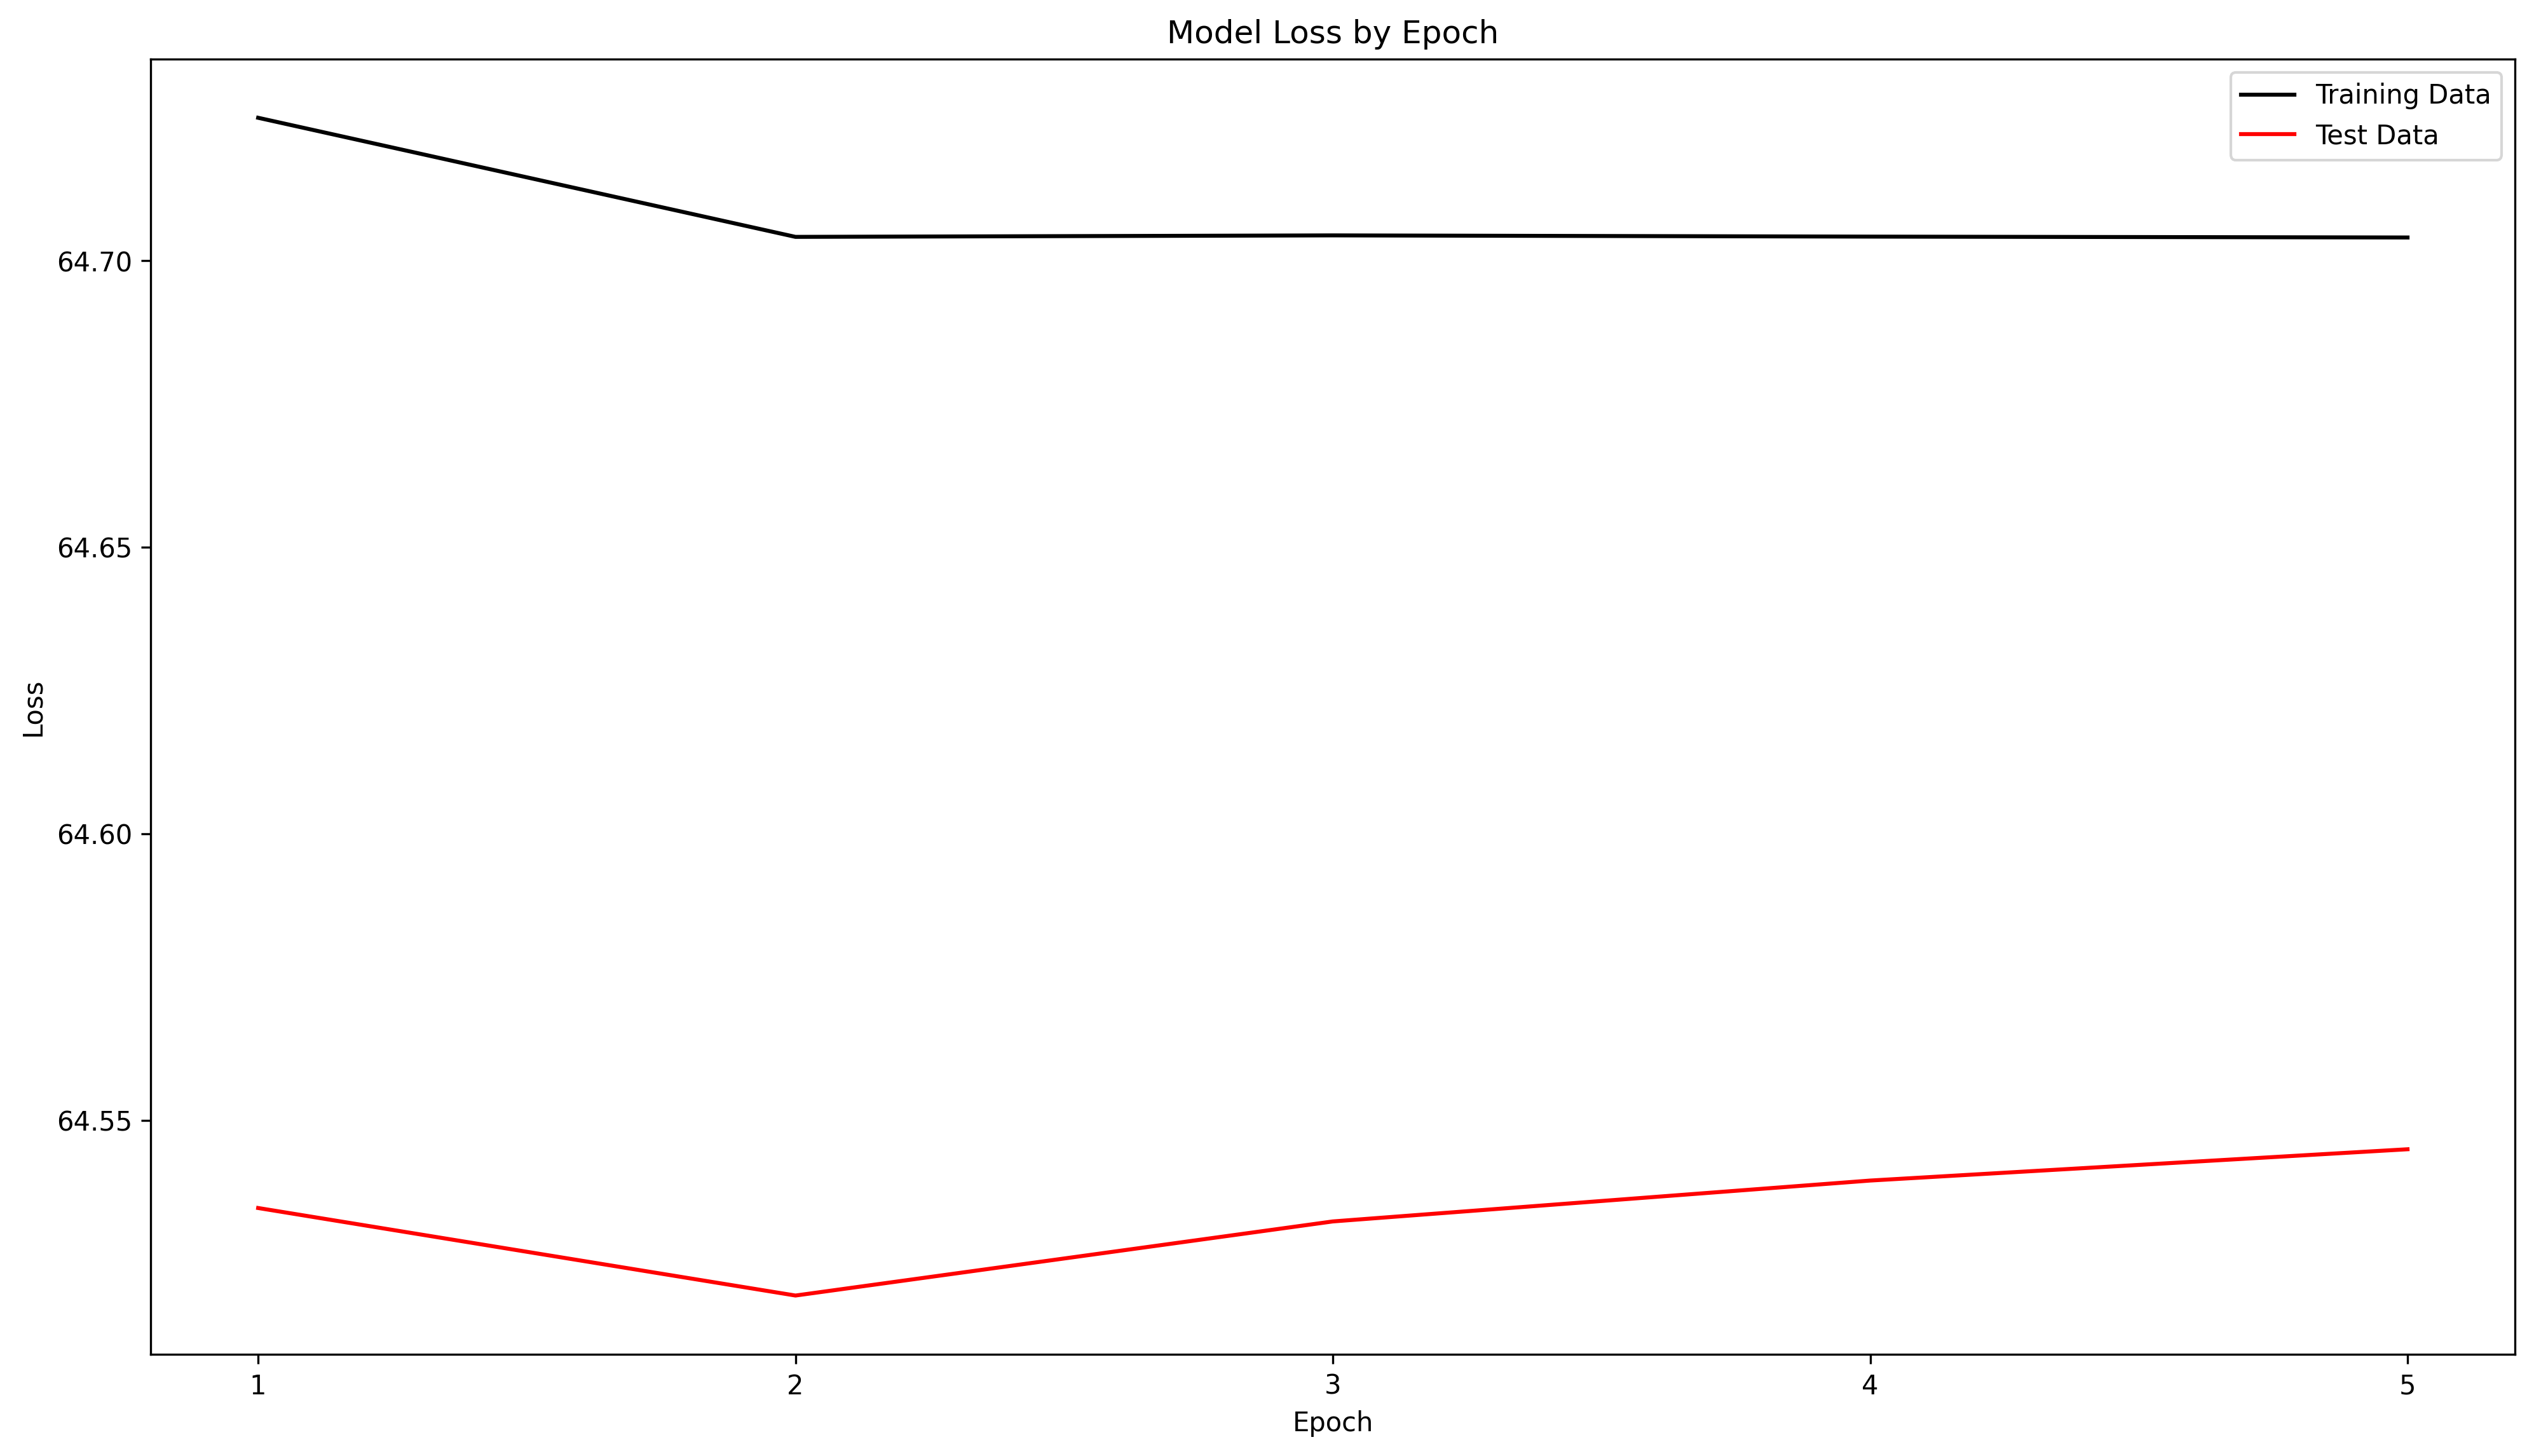

In [ ]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim_c * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Train VAE model
history = vae.fit(Xc_train, Xc_train, epochs=5, batch_size=16, validation_data=(Xc_test, Xc_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

1/1 [==============================] - 0s 11ms/step


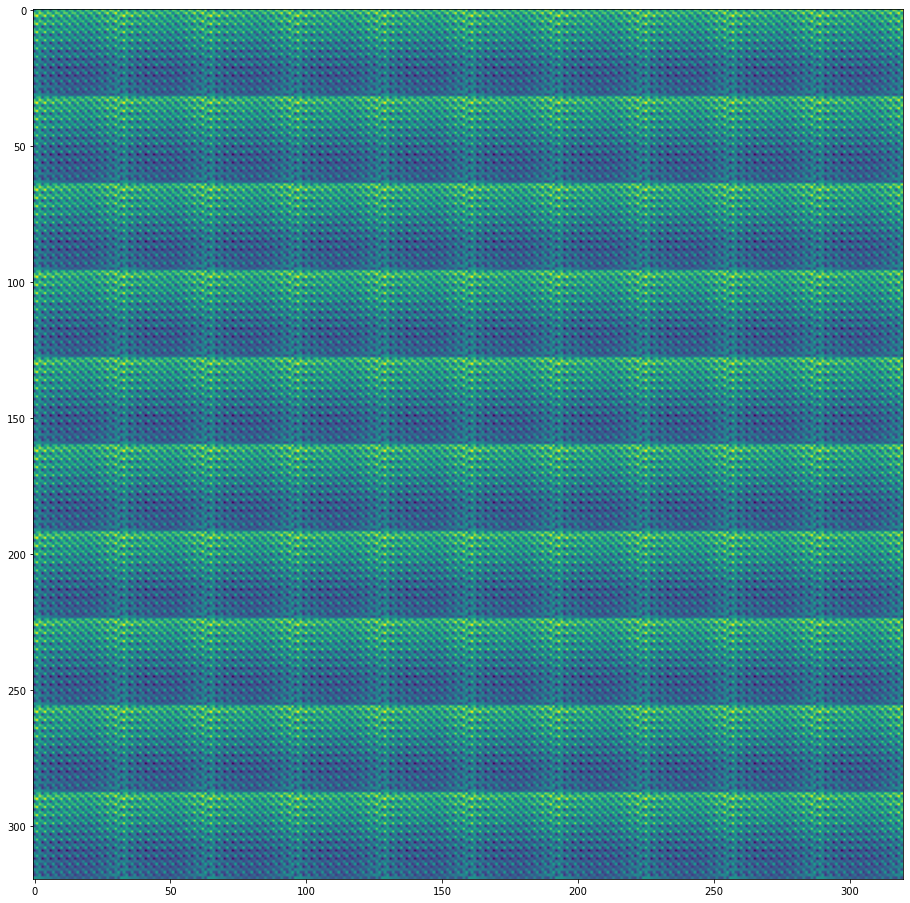

In [ ]:
n = 10  # figure with 10x10 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker
        
        # Reshape from 1024 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)*255
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

In [ ]:
x_decoded

array([[0.4645974 , 0.48504707, 0.48784575, ..., 0.46040744, 0.47314313,
        0.4608767 ]], dtype=float32)

In [ ]:
# train GAN via MNIST

from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=50, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=47% fake=48%
>2 real=55% fake=62%
>3 real=56% fake=77%
>4 real=57% fake=83%
>5 real=57% fake=95%
>6 real=49% fake=98%
>7 real=60% fake=99%
>8 real=52% fake=100%
>9 real=61% fake=99%
>10 real=55% fake=100%
>11 real=63% fake=100%
>12 real=55% fake=100%
>13 real=59% fake=100%
>14 real=62% fake=100%
>15 real=63% fake=100%
>16 real=66% fake=100%
>17 real=69% fake=100%
>18 real=76% fake=100%
>19 real=74% fake=100%
>20 real=75% fake=100%
>21 real=80% fake=100%
>22 real=83% fake=100%
>23 real=88% fake=100%
>24 real=91% fake=100%
>25 real=94% fake=100%
>26 real=96% fake=100%
>27 real=94% fake=100%
>28 real=97% fake=100%
>29 real=94% fake=100%
>30 real=98% fake=100%
>31 real=99% fake=100%
>32 real=100% fake=100%
>33 real=98% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=98% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake

In [ ]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 6ms/step
>1, 1/234, d=0.718, g=0.702
4/4 [==============================] - 0s 7ms/step
>1, 2/234, d=0.712, g=0.721
4/4 [==============================] - 0s 5ms/step
>1, 3/234, d=0.696, g=0.749
4/4 [==============================] - 0s 5ms/step
>1, 4/234, d=0.690, g=0.762
4/4 [==============================] - 0s 5ms/step
>1, 5/234, d=0.679, g=0.782
4/4 [==============================] - 0s 5ms/step
>1, 6/234, d=0.668, g=0.802
4/4 [==============================] - 0s 7ms/step
>1, 7/234, d=0.664, g=0.817
4/4 [==============================] - 0s 5ms/step
>1, 8/234, d=0.665, g=0.832
4/4 [==============================] - 0s 5ms/step
>1, 9/234, d=0.660, g=0.833
4/4 [==============================] - 0s 4ms/step
>1, 10/234, d=0.656, g=0.833
4/4 [==============================] - 0s 4ms/step
>1, 11/234, d=0.659, g=0.827
4/4 [==============================] - 0s 5ms/step
>1, 12/234, d=0.655, g=0.817
4/4 [==============================] - 0s 4ms/ste

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

OSError: ignored

In [ ]:
import numpy as np
n = 5  # figure with 10x10 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker
        
        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

ValueError: ignored

In [ ]:
# train GAN using MNIST
from __future__ import print_function, division
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [ ]:
import tensorflow_datasets
mnist = tensorflow_datasets.load('mnist')


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x,alpha * x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform(shape=(batch_size,dim), minval = -1, maxval = 1)

def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.layers.dense(x,256,activation=leaky_relu)
        x = tf.layers.dense(x,256,activation=leaky_relu)
        logits = tf.layers.dense(x,1,activation=None)
        return logits

def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        z = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        z = tf.layers.dense(z, 1024, activation = tf.nn.relu)
        img = tf.layers.dense(z, 784, activation = tf.nn.tanh)
        return img
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    part1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_real), logits = logits_real))
    part2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(logits_fake), logits = (logits_fake)))
    D_loss = part1 + part2
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(logits_fake), logits = logits_fake ))
    return D_loss, G_loss

def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1)
    return D_solver, G_solver

tf.compat.v1.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars) 
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/

In [ ]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

AttributeError: ignored